In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import torch
import logging
import os

import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
# Create simulated data 

def simulate_data(num_samples = 1000, num_metabolites = 50, num_batches = 5, lambda_base = 30000):
    
    data_np = np.random.poisson(lambda_base, (num_samples, num_metabolites))

    # introduce missingness in batches 
    batch_size = num_samples // num_batches
    for batch_idx in range(num_batches):
        affected_metabolites = np.random.choice(range(num_metabolites), size=num_metabolites // 10, replace=False)
    
        # Set the counts of the affected metabolites to zero in the current batch
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size if batch_idx < num_batches - 1 else num_samples
        data_np[start_idx:end_idx, affected_metabolites] = 0
    
    data = torch.tensor(data_np, dtype=torch.float32)
    
    return data


In [123]:
# Define the dimensions

#num_samples = len(metabolomics_data)
#num_metabolites = len(metabolomics_data.columns)

def model(data):
    
    #W_prior = dist.Normal(torch.zeros(num_samples, 1), 
     #                     torch.ones(num_samples, 1)).to_event(2)
    
    #H_prior = dist.Normal(torch.zeros(1, num_metabolites), 
    #                      torch.ones(1, num_metabolites)).to_event(2)
    
    W_prior = dist.HalfNormal(torch.ones(num_samples, 1)).to_event(2)
    H_prior = dist.HalfNormal(torch.ones(1, num_metabolites)).to_event(2)
    
   # W_prior = dist.LogNormal(torch.zeros(num_samples, 1), torch.ones(num_samples, 1)).to_event(2)
   # H_prior = dist.LogNormal(torch.zeros(1, num_metabolites), torch.ones(1, num_metabolites)).to_event(2)
    
    # Priors over Beta (batch effects)
    #Beta_prior = dist.Normal(torch.zeros(num_samples, num_metabolites), 
    #                         torch.ones(num_samples, num_metabolites)).to_event(2)
    
    
    Beta_prior = dist.Normal(loc=torch.zeros(num_samples, num_metabolites), 
                                scale=torch.ones(num_samples, num_metabolites)).to_event(2)
    
    # Sample from the priors
    W = pyro.sample("W", W_prior)
    H = pyro.sample("H", H_prior)
    Beta = pyro.sample("Beta", Beta_prior)

    # The mean parameter for the Poisson distribution
    lambda_ = torch.exp(torch.matmul(W, H) + Beta)
    
    # Observed data likelihood
    with pyro.plate("data", data.shape[0], dim=-2):
        with pyro.plate("features", data.shape[1], dim=-1):
            pyro.sample("obs", dist.Poisson(lambda_), obs=data)



In [150]:
def guide(data):

    # Variational parameters for W and H
    #latent_dim = 1
    
    # Variational parameters for W and H
    W_scale = pyro.param("W_scale", torch.ones(num_samples, 1), constraint=dist.constraints.positive)
    H_scale = pyro.param("H_scale", torch.ones(1, num_metabolites), constraint=dist.constraints.positive)
    
    # Variational parameters for Beta
    Beta_loc = pyro.param("Beta_loc", torch.zeros(num_samples, num_metabolites))
    Beta_scale = pyro.param("Beta_scale", torch.ones(num_samples, num_metabolites), constraint=dist.constraints.positive)
    
   
    #sample_means = torch.tensor(np.mean(data.numpy(), axis=1, keepdims=True))
    #metabolite_means = torch.tensor(np.mean(data.numpy(), axis=0, keepdims=True))
    W_loc = pyro.param("W_loc", 0.01 * torch.randn(num_samples, 1))
    H_loc = pyro.param("H_loc", 0.01 * torch.randn(1, num_metabolites))

    #W_loc = pyro.param("W_loc", torch.zeros(num_samples, 1))
    #W_scale = pyro.param("W_scale", torch.ones(num_samples, 1), constraint=dist.constraints.positive)
    #H_loc = pyro.param("H_loc", torch.zeros(1, num_metabolites))
    #H_scale = pyro.param("H_scale", torch.ones(1, num_metabolites), constraint=dist.constraints.positive)
    
    # Variational parameters for Beta
    #Beta_loc = pyro.param("Beta_loc", torch.rand(num_samples, num_metabolites))
    #Beta_scale = pyro.param("Beta_scale", torch.ones(num_samples, num_metabolites), constraint=dist.constraints.positive)
    
     # Variational distributions
    pyro.sample("W", dist.HalfNormal(W_scale).to_event(2))
    pyro.sample("H", dist.HalfNormal(H_scale).to_event(2))
    pyro.sample("Beta", dist.Normal(Beta_loc, Beta_scale).to_event(2))
    
    # Variational distributions
    #pyro.sample("W", dist.HalfNormal(W_loc, W_scale).to_event(2))
    #pyro.sample("H", dist.HalfNormal(H_loc, H_scale).to_event(2))
    #pyro.sample("Beta", dist.LogNormal(Beta_loc, Beta_scale).to_event(2))

In [144]:
def learn():
    
    # Setup the optimizer
    adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)

    # Setup the inference algorithm
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

    # The training loop
    num_iterations = 10000
    losses = []  # Store the losses here
    
    for j in range(num_iterations):
        # Calculate the loss and take a gradient step
        loss = svi.step(data)
        losses.append(loss)
        #if j % 100 == 0:
        #    print(f"Iteration {j} : loss = {loss}")
        if j % 100 == 0:
            print(f"Iteration {j} : loss = {loss}")
            W_learned = pyro.param("W_scale")
            H_learned = pyro.param("H_scale")
            Beta_learned = pyro.param("Beta_loc")
            print(f"W_learned mean: {W_learned.mean()}, std: {W_learned.std()}")
            print(f"H_learned mean: {H_learned.mean()}, std: {H_learned.std()}")
            print(f"Beta_learned mean: {Beta_learned.mean()}, std: {Beta_learned.std()}")

    # After training, you may want to retrieve the learned embeddings and Beta matrix
    W_learned = pyro.param("W_loc")
    H_learned = pyro.param("H_loc")
    Beta_learned = pyro.param("Beta_loc")
    
    plt.plot(losses)
    plt.title('SVI Loss During Training')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    
    return(W_learned, H_learned, Beta_learned)

In [46]:
data = simulate_data()
data

tensor([[30319., 30071., 30117.,  ..., 29994.,     0., 30247.],
        [29986., 30035., 30220.,  ..., 29971.,     0., 30056.],
        [30104., 30184., 29780.,  ..., 29789.,     0., 29784.],
        ...,
        [30035., 29898., 29972.,  ...,     0., 30256., 29984.],
        [29962., 30091., 30007.,  ...,     0., 29986., 29919.],
        [29850., 29988., 29965.,  ...,     0., 29973., 30149.]])

In [70]:
metadata_metabolomics = pd.read_csv("~/Desktop/reznik/metabolomics/metadata.csv", index_col = 0)
metadata_sub = metadata_metabolomics[metadata_metabolomics['Isotope_Label'].isna()]
metadata_batch = metadata_sub.iloc[:,-1:]
#batch_labels = metadata_batch.to_numpy()
batch_labels = np.asarray(metadata_batch).T

In [47]:
data_np = pd.read_csv("~/Desktop/reznik/metabolomics/master_file_metabolomics.csv", index_col = 0)
percent_missing = data_np.isnull().mean() * 100
filtered_df = data_np.loc[:, percent_missing <= 50]
filtered_df = filtered_df.replace(np.nan, 0)
data = torch.tensor(filtered_df.values, dtype=torch.float32).round()
data

tensor([[26.,  0., 15.,  ..., 31., 28., 21.],
        [25.,  0., 14.,  ..., 31., 28., 20.],
        [26.,  0., 15.,  ..., 31., 28., 20.],
        ...,
        [ 0.,  0.,  0.,  ..., 30.,  0., 13.],
        [ 0.,  0.,  0.,  ..., 29.,  0., 13.],
        [ 0.,  0.,  0.,  ..., 30.,  0., 14.]])

In [48]:
num_samples = data.shape[0]
num_metabolites = data.shape[1]
num_metabolites

35

Iteration 0 : loss = 1579359.75
W_learned mean: 1.0007511377334595, std: 0.0006609681877307594
H_learned mean: 1.0007718801498413, std: 0.0006456166156567633
Beta_learned mean: 0.0006536605069413781, std: 0.0007567978464066982
Iteration 100 : loss = 1516100.3678627014
W_learned mean: 1.0095573663711548, std: 0.019206803292036057
H_learned mean: 0.9990735650062561, std: 0.013482891023159027
Beta_learned mean: 0.055701952427625656, std: 0.05171329528093338
Iteration 200 : loss = 1425229.8848190308
W_learned mean: 1.0028022527694702, std: 0.022116644307971
H_learned mean: 0.9872332811355591, std: 0.014634865336120129
Beta_learned mean: 0.10295015573501587, std: 0.0947030559182167
Iteration 300 : loss = 1469377.9488315582
W_learned mean: 0.9976063966751099, std: 0.023971209302544594
H_learned mean: 0.9799339175224304, std: 0.016700105741620064
Beta_learned mean: 0.1468803882598877, std: 0.13353952765464783
Iteration 400 : loss = 1411953.0596504211
W_learned mean: 0.992195188999176, std: 0.

Iteration 3600 : loss = 773759.0377063751
W_learned mean: 0.8718694448471069, std: 0.046101901680231094
H_learned mean: 0.8578380942344666, std: 0.05373775586485863
Beta_learned mean: 1.0021835565567017, std: 0.8285974860191345
Iteration 3700 : loss = 783132.2877426147
W_learned mean: 0.8689343929290771, std: 0.046889424324035645
H_learned mean: 0.8552464246749878, std: 0.054624684154987335
Beta_learned mean: 1.0213539600372314, std: 0.8421547412872314
Iteration 3800 : loss = 847184.4702453613
W_learned mean: 0.8658114671707153, std: 0.047501642256975174
H_learned mean: 0.8529070019721985, std: 0.05539713427424431
Beta_learned mean: 1.0406162738800049, std: 0.855625569820404
Iteration 3900 : loss = 725211.1414489746
W_learned mean: 0.8621870875358582, std: 0.04837294667959213
H_learned mean: 0.8499574661254883, std: 0.05605147406458855
Beta_learned mean: 1.0597126483917236, std: 0.868880033493042
Iteration 4000 : loss = 728784.9700336456
W_learned mean: 0.8589996099472046, std: 0.04915

Iteration 7300 : loss = 445627.8185491562
W_learned mean: 0.7417744994163513, std: 0.07676529139280319
H_learned mean: 0.7303535342216492, std: 0.09893244504928589
Beta_learned mean: 1.6249922513961792, std: 1.2078155279159546
Iteration 7400 : loss = 469718.8178806305
W_learned mean: 0.7375937104225159, std: 0.07767283916473389
H_learned mean: 0.7260681986808777, std: 0.0997031107544899
Beta_learned mean: 1.639366865158081, std: 1.2148793935775757
Iteration 7500 : loss = 463188.0917491913
W_learned mean: 0.7338919639587402, std: 0.07843488454818726
H_learned mean: 0.7229702472686768, std: 0.10019845515489578
Beta_learned mean: 1.6542280912399292, std: 1.2221276760101318
Iteration 7600 : loss = 425880.0463027954
W_learned mean: 0.7299001812934875, std: 0.07959768176078796
H_learned mean: 0.7189646363258362, std: 0.10165989398956299
Beta_learned mean: 1.6679927110671997, std: 1.228439211845398
Iteration 7700 : loss = 415811.6167039871
W_learned mean: 0.7262371182441711, std: 0.0804471746

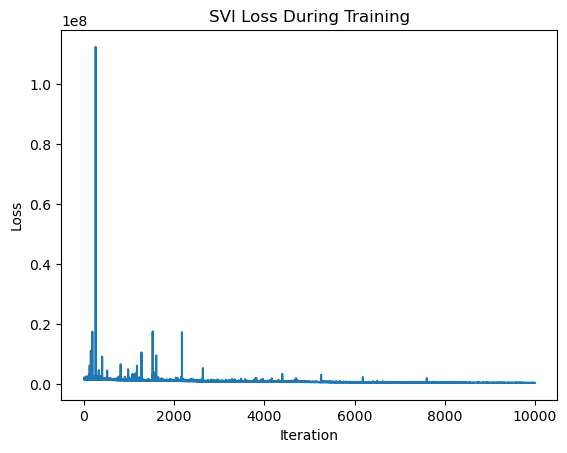

In [151]:
pyro.clear_param_store()
W_learned, H_learned, Beta_learned = learn()

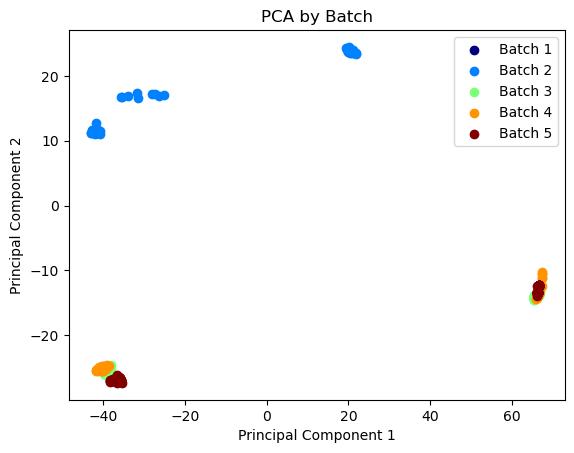

In [126]:

# Create a batch label for each sample
num_samples = data.shape[0]  # Number of samples in the simulated data
num_batches = 5  # As defined in simulate_data
#batch_labels = np.repeat(range(num_batches), num_samples / num_batches)

# Apply PCA and reduce the data to 2 principal components for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data.numpy())

# Create a DataFrame with the principal components and the batch information
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf['Batch'] = batch_labels.T

# Plotting the PCA
fig, ax = plt.subplots()

# Generate a color map for the number of batches
colors = plt.cm.jet(np.linspace(0, 1, num_batches))

# Color by batch
for batch, color in zip(range(num_batches), colors):
    idx = principalDf['Batch'] == batch
    ax.scatter(principalDf.loc[idx, 'PC1'], principalDf.loc[idx, 'PC2'], label=f'Batch {batch+1}', color=color)

plt.title('PCA by Batch')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

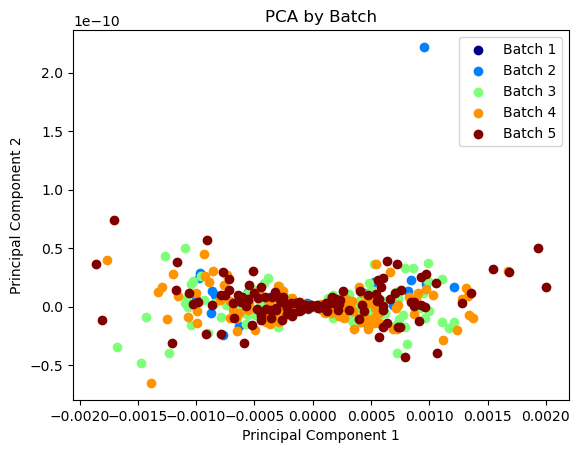

In [158]:
new_data = (torch.matmul(W_learned,H_learned)) 

# Create a batch label for each sample
num_samples = data.shape[0]  # Number of samples in the simulated data
num_batches = 5  # As defined in simulate_data
#batch_labels = np.repeat(range(num_batches), num_samples / num_batches)

# Apply PCA and reduce the data to 2 principal components for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(new_data.detach().numpy())

# Create a DataFrame with the principal components and the batch information
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf['Batch'] = batch_labels.T

# Plotting the PCA
fig, ax = plt.subplots()

# Generate a color map for the number of batches
colors = plt.cm.jet(np.linspace(0, 1, num_batches))

# Color by batch
for batch, color in zip(range(num_batches), colors):
    idx = principalDf['Batch'] == batch
    ax.scatter(principalDf.loc[idx, 'PC1'], principalDf.loc[idx, 'PC2'], label=f'Batch {batch+1}', color=color)

plt.title('PCA by Batch')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [155]:
torch.exp(new_data + Beta_learned)

tensor([[17.1797,  0.4586,  7.4811,  ..., 19.7838, 16.7719, 12.6041],
        [16.0106,  0.4560,  7.2518,  ..., 22.7723, 16.2204, 11.8306],
        [17.7627,  0.4694,  7.9845,  ..., 22.5525, 17.6326, 12.0970],
        ...,
        [ 0.4554,  0.4551,  0.4334,  ..., 21.6336,  0.4438,  6.7217],
        [ 0.4554,  0.4496,  0.4188,  ..., 19.2959,  0.4181,  6.6931],
        [ 0.4425,  0.4497,  0.4780,  ..., 21.2774,  0.4358,  7.5945]],
       grad_fn=<ExpBackward0>)

In [154]:
torch.exp(data)

tensor([[1.9573e+11, 1.0000e+00, 3.2690e+06,  ..., 2.9049e+13, 1.4463e+12,
         1.3188e+09],
        [7.2005e+10, 1.0000e+00, 1.2026e+06,  ..., 2.9049e+13, 1.4463e+12,
         4.8517e+08],
        [1.9573e+11, 1.0000e+00, 3.2690e+06,  ..., 2.9049e+13, 1.4463e+12,
         4.8517e+08],
        ...,
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0686e+13, 1.0000e+00,
         4.4241e+05],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.9313e+12, 1.0000e+00,
         4.4241e+05],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0686e+13, 1.0000e+00,
         1.2026e+06]])

In [77]:
data

tensor([[26.,  0., 15.,  ..., 31., 28., 21.],
        [25.,  0., 14.,  ..., 31., 28., 20.],
        [26.,  0., 15.,  ..., 31., 28., 20.],
        ...,
        [ 0.,  0.,  0.,  ..., 30.,  0., 13.],
        [ 0.,  0.,  0.,  ..., 29.,  0., 13.],
        [ 0.,  0.,  0.,  ..., 30.,  0., 14.]])

In [131]:
new_data = (torch.matmul(W_learned,H_learned)) 
new_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<MmBackward0>)

(1083, 80)

torch.Size([1083, 35])

tensor([[25.6907,  0.0000, 15.2084,  ..., 30.7844, 28.2231, 20.5496],
        [25.1415,  0.0000, 13.9826,  ..., 30.6141, 28.1570, 20.0306],
        [25.6284,  0.0000, 15.2096,  ..., 30.8036, 28.1498, 19.7547],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., 29.5578,  0.0000, 12.9660],
        [ 0.0000,  0.0000,  0.0000,  ..., 29.3405,  0.0000, 13.2660],
        [ 0.0000,  0.0000,  0.0000,  ..., 29.5661,  0.0000, 14.2465]])

Contains negative infinity: False


In [113]:
H_learned

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)

In [128]:
new_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<MmBackward0>)

In [135]:
Beta_learned

tensor([[ 2.9910, -0.6842,  2.4141,  ...,  3.2414,  3.0581,  2.8344],
        [ 2.9619, -0.6874,  2.4087,  ...,  3.2191,  3.1154,  2.7513],
        [ 3.0292, -0.7032,  2.4850,  ...,  3.2828,  3.1215,  2.7384],
        ...,
        [-0.6842, -0.7120, -0.7683,  ...,  3.1884, -0.7060,  2.1991],
        [-0.6606, -0.7516, -0.6520,  ...,  3.2024, -0.7741,  2.2634],
        [-0.7033, -0.7968, -0.7323,  ...,  3.2250, -0.7886,  2.3532]],
       requires_grad=True)